In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fitsio

%load_ext autoreload

%autoreload 2

%matplotlib notebook
sns.set()

In [2]:
import galsim

In [55]:
import tqdm
import ngmix

def _ngmix_g1g2(im, scale=0.263, fwhm=0.9):
    T = ngmix.moments.fwhm_to_T(fwhm)

    # the weight is always centered at 0, 0 or the
    # center of the coordinate system as defined
    # by the jacobian
    weight = ngmix.GMixModel(
        [0.0, 0.0, 0.0, 0.0, T, 1.0],
        'gauss',
    )

    # make the max of the weight 1.0 to get better
    # fluxes
    weight.set_norms()
    norm = weight.get_data()['norm'][0]
    weight.set_flux(1.0/norm)

    obs = ngmix.Observation(
        image=im,
        jacobian=ngmix.DiagonalJacobian(scale=scale, row=8, col=8))
    res = weight.get_weighted_moments(obs=obs, maxrad=1.e9)
    return res['e'][0], res['e'][1]

def _get_fwhm_g1g2(psf_im):
    g1, g2 = _ngmix_g1g2(psf_im.array, fwhm=0.9)
    mom = galsim.hsm.FindAdaptiveMom(psf_im)
    #         mom.observed_shape.g1, 
    #         mom.observed_shape.g2,
    return (
        mom.moments_sigma * psf_im.scale * 2.355, 
        g1, g2,
        psf_im.calculateFWHM())


def _measure_atm(ims, scale):
    n = ims.shape[0]
    fwhms = np.zeros((n, n))
    g1 = np.zeros_like(fwhms)
    g2 = np.zeros_like(fwhms)
    for i in tqdm.trange(n):
        for j in range(n):
            psf_im = galsim.ImageD(ims[j, i], scale=scale)
            res = _get_fwhm_g1g2(psf_im)
            fwhms[j, i] = res[0]
            g1[j, i] = res[1]
            g2[j, i] = res[2]
    return fwhms, g1, g2

In [69]:
d = fitsio.read('test_seed10_n1e6.fits')

In [70]:
fwhms, g1, g2 = _measure_atm(d['flat_image'].reshape(225, 225, 17, 17), d['scale'][0])

100%|██████████| 225/225 [01:02<00:00,  3.95it/s]


Text(0.5, 1.0, 'g2')

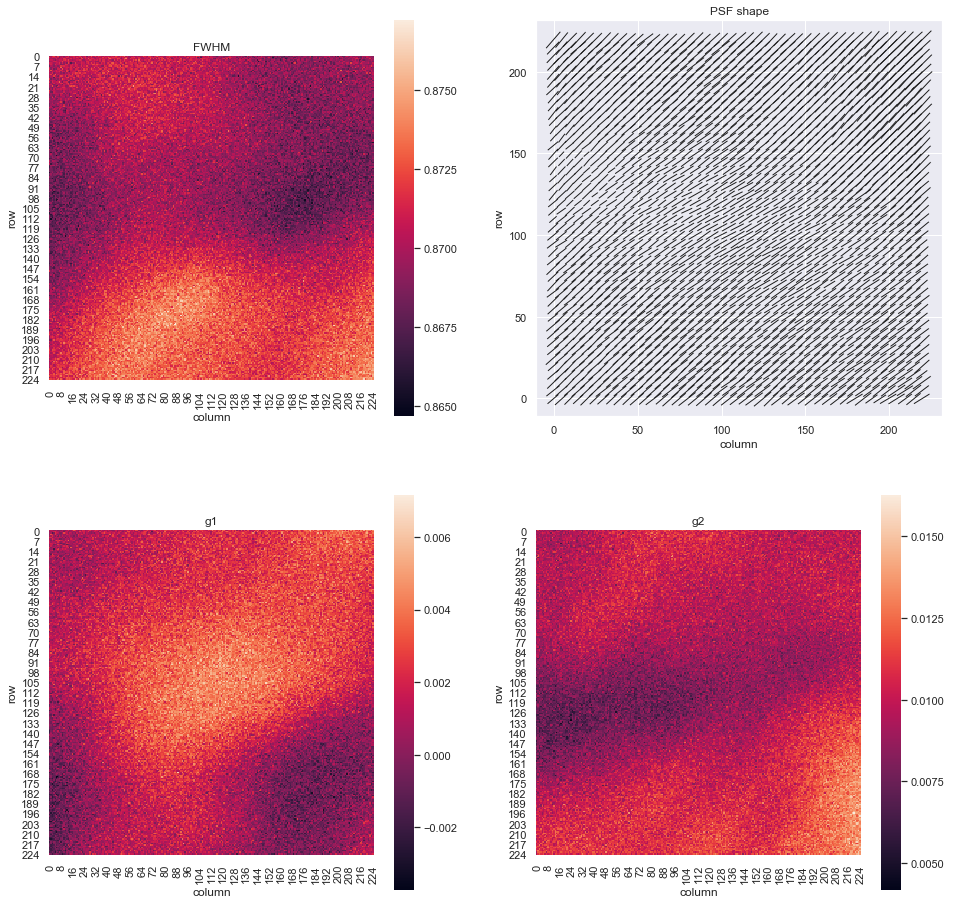

In [71]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

kwargs = {}
sns.heatmap(fwhms, square=True, ax=axs[0, 0], **kwargs)
axs[0, 0].set_xlabel('column')
axs[0, 0].set_ylabel('row')
axs[0, 0].set_title('FWHM')

g = np.sqrt(g1**2 + g2**2)
g /= np.mean(g)
loc = np.arange(g.shape[0]) + 0.5
beta = np.arctan2(g2, g1)/2
axs[0, 1].quiver(
    loc[::5],
    loc[::5],
    (g * np.cos(beta))[::5, ::5],
    (g * np.sin(beta))[::5, ::5],
    scale_units='xy',
    scale=0.075,
    headwidth=0,
    pivot='mid')
axs[0, 1].set_xlabel('column')
axs[0, 1].set_ylabel('row')
axs[0, 1].set_title('PSF shape')

sns.heatmap(g1, square=True, ax=axs[1, 0], **kwargs)
axs[1, 0].set_xlabel('column')
axs[1, 0].set_ylabel('row')
axs[1, 0].set_title('g1')

sns.heatmap(g2, square=True, ax=axs[1, 1], **kwargs)
axs[1, 1].set_xlabel('column')
axs[1, 1].set_ylabel('row')
axs[1, 1].set_title('g2')

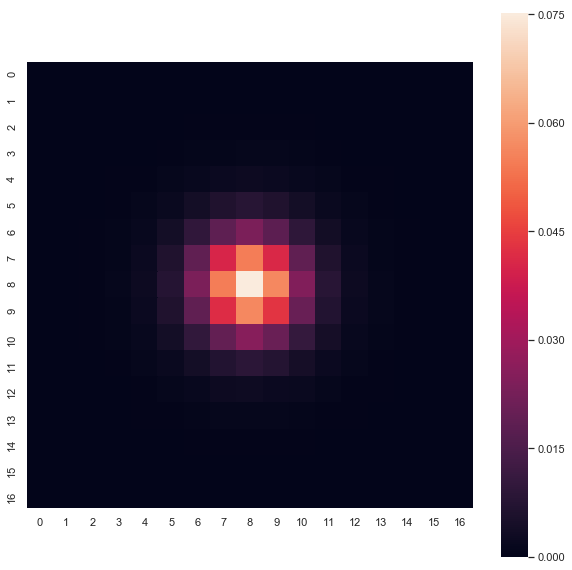

In [72]:
ims = d['flat_image'].reshape(225, 225, 17, 17)
msk = g1 == np.min(g1)
plt.figure(figsize=(10, 10))
sns.heatmap(ims[msk][0], square=True)

In [74]:
from sklearn.decomposition import PCA

In [149]:
X = d['flat_image'].reshape(225, 225, 17, 17).reshape(-1, 17 * 17)
p = PCA(n_components=50)
yc = p.fit_transform(X)

In [150]:
yc.shape

(50625, 50)

In [151]:
np.sum(p.explained_variance_ratio_)

0.9849316028399749

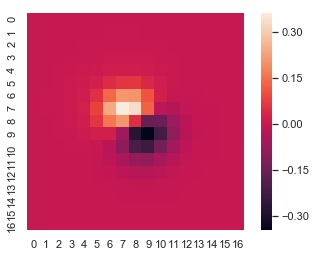

In [139]:
plt.figure()
sns.heatmap(p.components_[0, :].reshape(17, 17), square=True)

In [140]:
c = p.transform(X[0:1, :])

In [141]:
rim = p.inverse_transform(c)[0, :].reshape(17, 17)

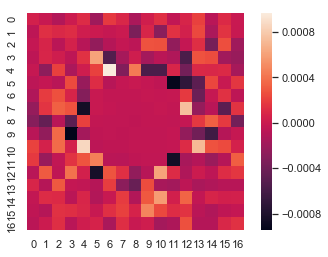

In [142]:
plt.figure()
sns.heatmap((rim - X[0, :].reshape(17, 17))/np.max(X[0, :]), square=True)

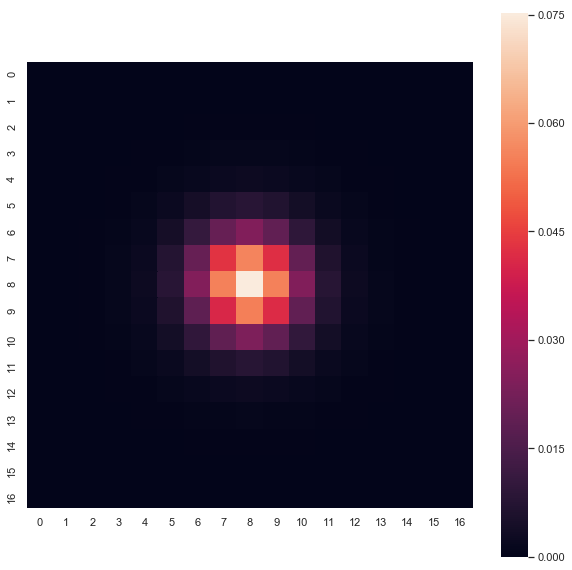

In [143]:
plt.figure(figsize=(10, 10))
sns.heatmap(rim, square=True)

In [144]:
nse = np.std(X[0, :].reshape(17, 17)[:, 0])
rnse = np.std(rim[:, 0])
print(nse, np.sqrt(np.sum(X[0, :]**2) / nse / nse))
print(rnse, np.sqrt(np.sum(rim**2) / rnse / rnse))

4.0802028e-05 4356.1387
3.7446152241660874e-05 4746.125329201316


In [156]:
Xc = []
locs = np.arange(225) / 225
for y in locs[::10]:
    for x in locs[::10]:
        Xc.append([y, x])
Xc = np.array(Xc)

In [158]:
_yc = yc.reshape((225, 225, 50))[::10, ::10, :].reshape(-1, 50)

In [256]:
import tqdm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

kernel = ConstantKernel() * RBF()

im_var = np.abs(p.mean_ * 1e6)
c_std = np.sqrt(np.dot(p.components_**2, im_var)) / 1e6

gps = []
for ind in tqdm.trange(50):
    dy = c_std[ind]
    gp = GaussianProcessRegressor(kernel=kernel, alpha=dy*dy)
    gp.fit(Xc, _yc[:, ind])
    gps.append(gp)

100%|██████████| 50/50 [00:18<00:00,  2.91it/s]


In [257]:
_x = 2
_y = 3
Xp = np.array([[_x, _y]]) / 225
c = np.array([[gp.predict(Xp)[0] for gp in gps]])
rim = p.inverse_transform(c)[0].reshape(17, 17)

In [258]:
im = d['flat_image'].reshape(225, 225, 17, 17)[_y, _x, :, :]
nse = np.std(im[:, 0])
rnse = np.std(rim[:, 0])
print(nse, np.sqrt(np.sum(im**2) / nse / nse))
print(rnse, np.sqrt(np.sum(rim**2) / rnse / rnse))

3.614361e-05 4917.9917
3.726709409652342e-05 4768.615700853058


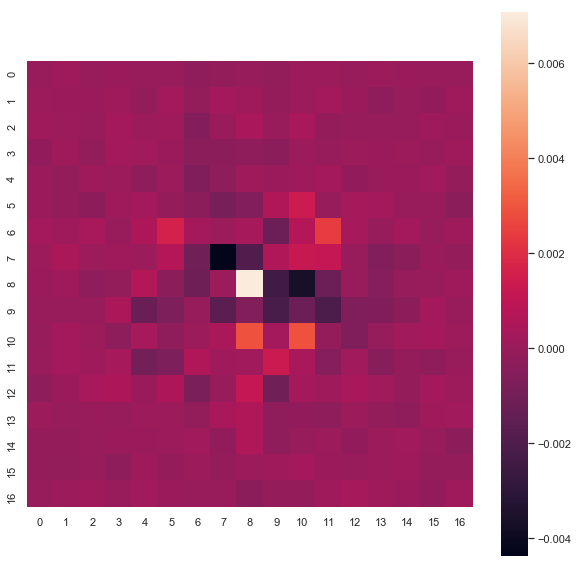

In [259]:
plt.figure(figsize=(10, 10))
sns.heatmap((rim - im)/np.max(im), square=True)

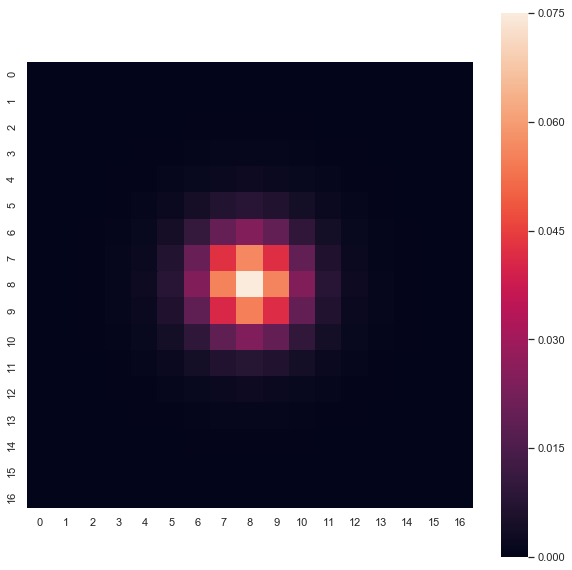

In [260]:
plt.figure(figsize=(10, 10))
sns.heatmap(rim, square=True)

In [262]:
def _make_pca_image(_x, _y):
    Xp = np.array([[_x, _y]]) / 225
    c = np.array([[gp.predict(Xp)[0] for gp in gps]])
    rim = p.inverse_transform(c)[0].reshape(17, 17)    
    return rim

ims = np.zeros((225, 225, 17, 17))
for y in tqdm.trange(225):
    for x in range(225):
        ims[y, x] = _make_pca_image(x, y)
fwhms, g1, g2 = _measure_atm(ims, d['scale'][0])

100%|██████████| 225/225 [01:00<00:00,  3.76it/s]


Text(0.5, 1.0, 'g2')

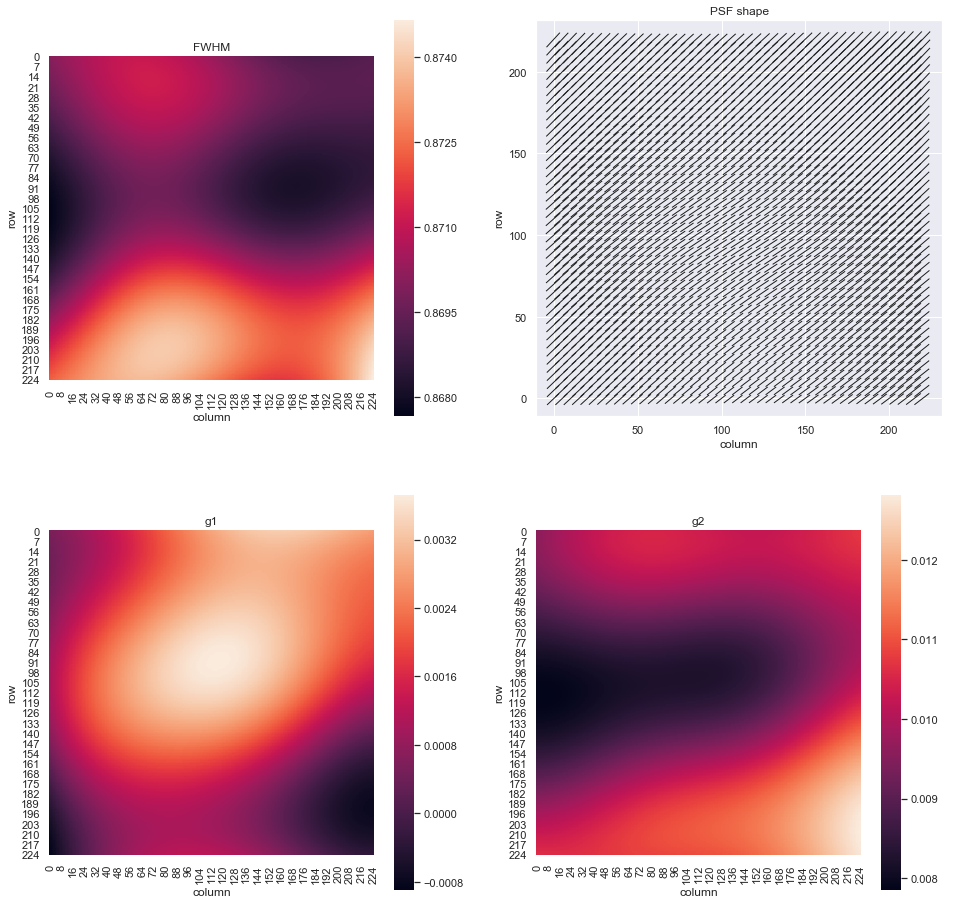

In [265]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

kwargs = {}
sns.heatmap(fwhms.T, square=True, ax=axs[0, 0], **kwargs)
axs[0, 0].set_xlabel('column')
axs[0, 0].set_ylabel('row')
axs[0, 0].set_title('FWHM')

g = np.sqrt(g1**2 + g2**2)
g /= np.mean(g)
loc = np.arange(g.shape[0]) + 0.5
beta = np.arctan2(g2.T, g1.T)/2
axs[0, 1].quiver(
    loc[::5],
    loc[::5],
    (g * np.cos(beta))[::5, ::5],
    (g * np.sin(beta))[::5, ::5],
    scale_units='xy',
    scale=0.075,
    headwidth=0,
    pivot='mid')
axs[0, 1].set_xlabel('column')
axs[0, 1].set_ylabel('row')
axs[0, 1].set_title('PSF shape')

sns.heatmap(g1.T, square=True, ax=axs[1, 0], **kwargs)
axs[1, 0].set_xlabel('column')
axs[1, 0].set_ylabel('row')
axs[1, 0].set_title('g1')

sns.heatmap(g2.T, square=True, ax=axs[1, 1], **kwargs)
axs[1, 1].set_xlabel('column')
axs[1, 1].set_ylabel('row')
axs[1, 1].set_title('g2')